# Abalone Rings Regression using Classical Machine Learning Algorithms

## Comparison on Linear Regression, Ridge Regression, Lasso Regression, Random Forest and Decision Tree

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
data = pd.read_csv('data/abalone.csv')

In [3]:
data['Sex'] = data['Sex'].map({'M': 0, 'F': 1, 'I': 2})

X = data.drop('Rings', axis=1)
y = data['Rings']

In [4]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [5]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, criterion='squared_error', random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'alpha': [0.1, 1, 10, 100]},
    'Lasso Regression': {'alpha': [0.1, 1, 10, 100]},
    'Random Forest': {
        'n_estimators': [100, 200, 300], 
        'max_depth': [None, 10, 20, 30], 
        'min_samples_split': [2, 5, 10], 
        'min_samples_leaf': [1, 2, 4]
    },
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
}

In [6]:
results = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    
    best_model = grid_search.best_estimator_
    
    y_val_pred = best_model.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    y_test_pred = best_model.predict(X_test_scaled)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    cv_scores = cross_val_score(best_model, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=5)
    
    results[name] = {
        'Test Prediction': y_test_pred,
        'Best Parameters': grid_search.best_params_,
        'Validation MAE': val_mae,
        'Validation MSE': val_mse,
        'Validation r2': val_r2,
        'Test MAE': test_mae,
        'Test MSE': test_mse,
        'Test r2': test_r2,
        'Cross-Validation Mean': cv_scores.mean(),
        'Cross-Validation Std': cv_scores.std()
    }
    
    print(f"\t{name} - Validation MAE: {val_mae:.4f}")
    print(f"\t{name} - Validation MSE: {val_mse:.4f}")
    print(f"\t{name} - Validation r2: {val_r2:.4f}")
    print(f"\t{name} - Test MAE: {test_mae:.4f}")
    print(f"\t{name} - Test MSE: {test_mse:.4f}")
    print(f"\t{name} - Test r2: {test_r2:.4f}")
    print(f"\t{name} - CV MAE: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"\t{name} - Best Parameters: {grid_search.best_params_}")

Training Linear Regression...
	Linear Regression - Validation MAE: 1.5851
	Linear Regression - Validation MSE: 4.8225
	Linear Regression - Validation r2: 0.5755
	Linear Regression - Test MAE: 1.5812
	Linear Regression - Test MSE: 4.7242
	Linear Regression - Test r2: 0.5348
	Linear Regression - CV MAE: -1.6075 (+/- 0.0577)
	Linear Regression - Best Parameters: {}
Training Ridge Regression...
	Ridge Regression - Validation MAE: 1.5851
	Ridge Regression - Validation MSE: 4.8231
	Ridge Regression - Validation r2: 0.5754
	Ridge Regression - Test MAE: 1.5812
	Ridge Regression - Test MSE: 4.7232
	Ridge Regression - Test r2: 0.5349
	Ridge Regression - CV MAE: -1.6075 (+/- 0.0579)
	Ridge Regression - Best Parameters: {'alpha': 0.1}
Training Lasso Regression...
	Lasso Regression - Validation MAE: 1.6578
	Lasso Regression - Validation MSE: 5.4035
	Lasso Regression - Validation r2: 0.5244
	Lasso Regression - Test MAE: 1.6330
	Lasso Regression - Test MSE: 5.0367
	Lasso Regression - Test r2: 0.5040


In [13]:
best_model = max(results, key=lambda x: results[x]['Test r2'])
print(f"Best performing model: {best_model}")

Best performing model: Random Forest


In [14]:
y_pred = results[best_model]['Test Prediction']
residuals = y_test - y_pred

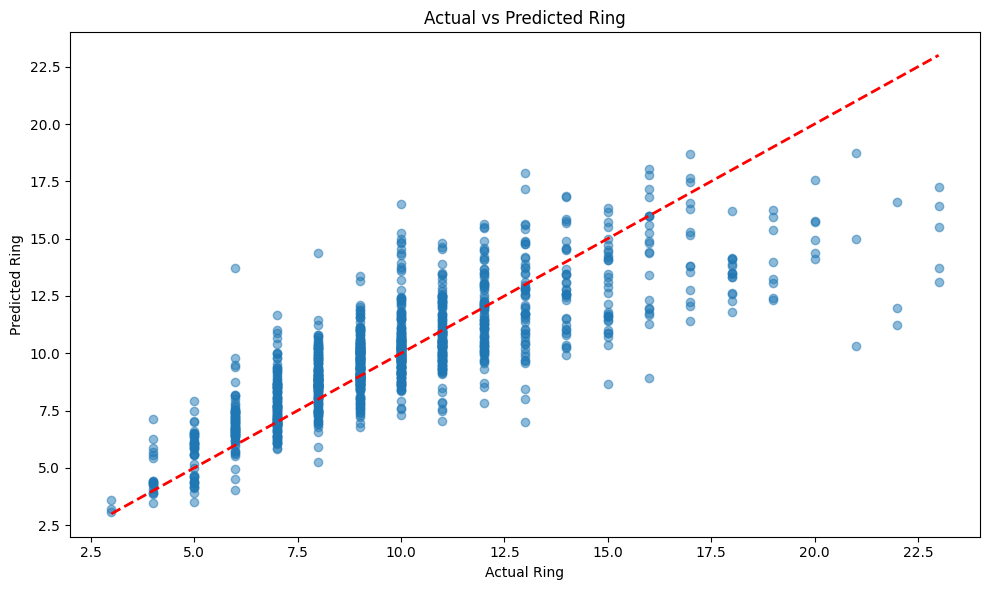

In [15]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Ring')
plt.ylabel('Predicted Ring')
plt.title('Actual vs Predicted Ring')
plt.tight_layout()
plt.show()
plt.close()

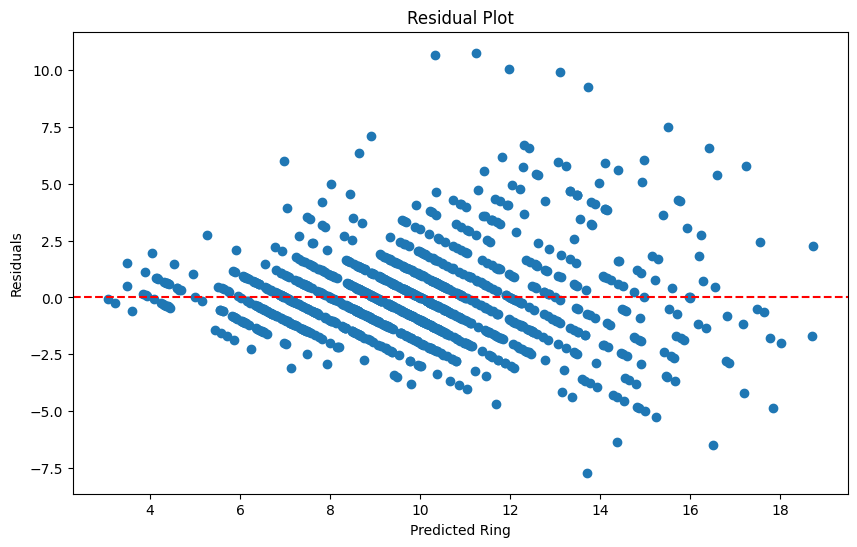

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Ring')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()
plt.close()

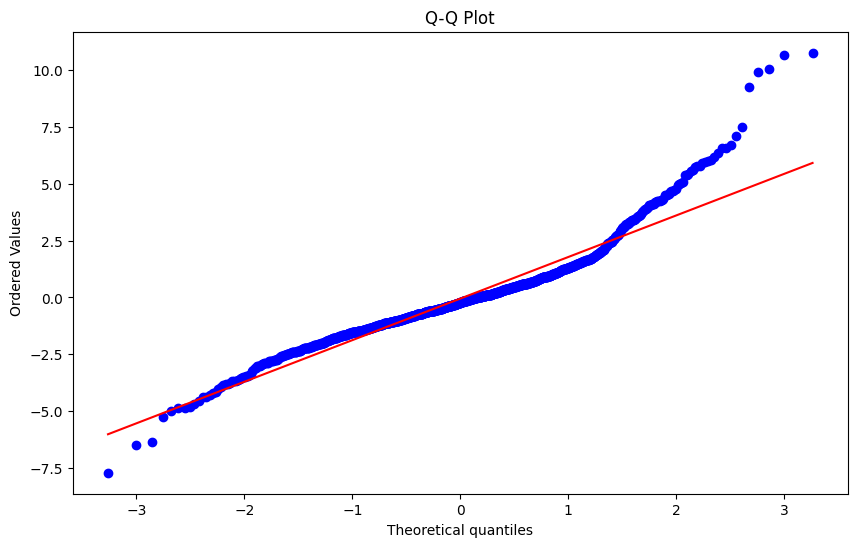

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=ax)
ax.set_title("Q-Q Plot")
plt.show()
plt.close()

In [18]:
print("Statistical Tests for Residuals:")
print(f"Mean of residuals: {np.mean(residuals):.4f}")
print(f"Shapiro-Wilk test: {stats.shapiro(residuals)}")

Statistical Tests for Residuals:
Mean of residuals: -0.0522
Shapiro-Wilk test: ShapiroResult(statistic=0.9229926466941833, pvalue=8.148858209147056e-25)
